## 5.1 Installation and Setup (Colab)

In [ ]:
!git clone https://github.com/opendp/smartnoise-sdk

Check smartnoise-sdk is downloaded

In [1]:
!ls

Go into the folder that setup.py located

In [2]:
cd smartnoise-sdk/synth

/home/ec2-user/SageMaker/smartnoise-sdk/synth


In [2]:
!ls

build  HISTORY.md      README.md  smartnoise_synth.egg-info  VERSION
dist   Makefile        samples	  snsynth
docs   pyproject.toml  setup.py   tests


In [ ]:
!python setup.py build

In [ ]:
!python setup.py install

***Note: If you need to install the related packages below, after running "pip" you should restart runtime (in Colab environment). Only after restarting the runtime can the Colab succesfully has the packages loaded in the environemnt and then you are able to run the following cells.***

In [2]:
!pip install diffprivlib 

In [3]:
!pip install opacus

In [4]:
!pip install threadpoolctl

In [5]:
!pip install ctgan==0.4.3

Now we are able to import the synthesizer. Also, due to the previous `cd smartnoise-sdk/synth` command, our jupyter notebook is inside smartnoise-sdk/synth so importing `snsynth` shall not run into any problem!

In [6]:
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from diffprivlib.models import LogisticRegression as DPLR
from sklearn.metrics import classification_report
from snsynth.mwem import MWEMSynthesizer

import warnings
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN
from snsynth.pytorch.nn import PATECTGAN
warnings.filterwarnings("ignore")

/Users/wenlingong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
def process_COMPAS(temp_df, is_GAN = False):
    """
    Pick columns = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 
    'juv_other_count', 'length_of_stay','race','two_year_recid', 'c_charge_degree'] 
    from the dataframe. Convert category data into numeric and remove races other 
    than Caucasian or African-American. 
    
    Input: COMPAS dataframe
    Output: 
           COMPAS dataframe after cleaning
            age_cat                    int64
            priors_count               int64
            sex_numeric                int64
            juv_fel_count              int64
            juv_misd_count             int64
            juv_other_count            int64
            c_charge_degree_numeric    int64
            length_of_stay             int64
            race                       int64
            two_year_recid             int64
    """
    # deepcopy
    df = temp_df.copy()
    
    # remove invalid/null entries
    df = df[(df['days_b_screening_arrest'] <= 30)
                & (df['days_b_screening_arrest'] >= -30)
                & (df['is_recid'] != -1)
                & (df['c_charge_degree'] != 'O')
                & (df['score_text'] != 'N/A')]
    # remove races other than Caucasian or African-American
    df = df[(df['race']=='Caucasian') | (df['race']=='African-American')]

    # calculate length_of_stay
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
    # the number of seconds to the unix epoch start
    df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).astype(int) / 10**9 
    # convert seconds into month
    df['length_of_stay'] /= 60 * 60 * 24 * 31
    df['length_of_stay'] = df['length_of_stay'].astype(int)
    df = df.drop_duplicates()

    # convert category data into numeric
    df['sex_numeric'] = pd.factorize(df['sex'])[0]
    df['c_charge_degree_numeric'] = pd.factorize(df['c_charge_degree'])[0]
    race = {0: 'Caucasian', 1: 'African-American'}
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    if is_GAN:
      # don't need to bin age
      df["age_cat"] = df["age"]
    else:
      age = {1: 'Greater than 45', 0: '25 - 45', -1: 'Less than 25'}
      df["age_cat"] = df["age_cat"].map({v: k for k, v in age.items()})

    cols = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree_numeric', 'length_of_stay','race','two_year_recid']
    df = df[cols]
    
    return df

In [8]:
def logisticRegression(x_train, y_train, x_test):
    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=500)
    logisticRegr.fit(x_train, y_train)

    train_predictions = logisticRegr.predict(x_train)
    test_predictions = logisticRegr.predict(x_test)
    return train_predictions, test_predictions

In [9]:
def predictionSummary(temp_x, y_real, y_predict, df):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict, labels=[0, 1]).ravel()
    # False Positive, False Negative, True Positive, True Negative, Overall Accuracy
    overall = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/y_real.shape[0]]

    x = temp_x.copy()
    x['medium_or_high_risk'] = y_predict
    x['two_year_recid'] = y_real
    
    # African-American
    x_black = x[df['race']==1].copy()
    tn, fp, fn, tp = confusion_matrix(x_black['two_year_recid'], x_black['medium_or_high_risk'], labels=[0, 1]).ravel()
    black = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    # Caucasian
    x_white = x[df['race']==0].copy()
    tn, fp, fn, tp = confusion_matrix(x_white['two_year_recid'], x_white['medium_or_high_risk'], labels=[0, 1]).ravel()
    white = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    return overall, black, white

In [163]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    def QuailSynth(epsilon):
      if synthesizer == "MWEM": 
          return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
      if synthesizer == "PATECTGAN":
          return PytorchDPSynthesizer(epsilon, PATECTGAN(regularization='dragan'), None)
#           return PytorchDPSynthesizer(epsilon=epsilon, preprocessor=None, gan=PATECTGAN(loss='cross_entropy', batch_size=50))
      if synthesizer == "DPCTGAN":
          return PytorchDPSynthesizer(epsilon, DPCTGAN(), None)
        
    # Instantiate a DPLR classifier
    def QuailClassifier(epsilon):
      return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split) ## none for classifier

    return quail

In [113]:
def synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM", all_results = False):
    test_results, train_results = [],[]
    if all_results: 
        test_all_results, test_synth_all_results, train_all_results = [],[],[]
    recid_ratio, race_ratio, recid_ratio_avg, race_ratio_avg = [],[],[],[]
    table, table00, table01, table10, table11 = [], [], [], [], []
    # Loop through range of epsilon values
    for epsilon in epsilons:
        print(str(epsilon)+": ", end="")
        train_overall, train_black, train_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        test_overall, test_black, test_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        
        recid_ratio.append([])
        race_ratio.append([])
        table.append([])
    
        # Generate synthetic data many times (to average results)
        for i in range(niteration):
            print(str(i), end=", ")
            while True:
              # Generate synthetic training data
              if synthesizer == "MWEM":
                  synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15,
                                        splits=[], split_factor=6, max_bin_count=400) 
                  # learn the distribution of the real data
                  fit = synth.fit(train_data.to_numpy())  
              if synthesizer == "QUAIL":
                  synth = get_quail_synthesizer("MWEM", None, epsilon, None, target="two_year_recid")
                  fit = synth.fit(train_data)  
              if synthesizer == "DPCTGAN":
                  synth = PytorchDPSynthesizer(epsilon, DPCTGAN(), None)
                  fit = synth.fit(train_data, ['race','sex_numeric','c_charge_degree_numeric','c_charge_degree_numeric','two_year_recid'])
              if synthesizer == "PATECTGAN":
                  synth = PytorchDPSynthesizer(epsilon, PATECTGAN(regularization='dragan'), None)
                  fit = synth.fit(train_data, ['race','sex_numeric','c_charge_degree_numeric','c_charge_degree_numeric','two_year_recid'])
              if synthesizer == "PATECTGANQUAIL":
                  synth = get_quail_synthesizer("PATECTGAN", None, epsilon, None, target="two_year_recid")
                  fit = synth.fit(train_data, ['race','sex_numeric','c_charge_degree_numeric','c_charge_degree_numeric','two_year_recid'])
              if synthesizer == "DPCTGANQUAIL":
                  synth = get_quail_synthesizer("DPCTGAN", None, epsilon, None, target="two_year_recid")
                  fit = synth.fit(train_data, ['race','sex_numeric','c_charge_degree_numeric','c_charge_degree_numeric','two_year_recid'])
              
              if not all_results:
                  # generate synthetic train data
                  train_synth = pd.DataFrame(synth.sample(train_data.shape[0]), columns=train_data.columns) 
                  # Split synthetic training data into X and y
                  x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]
              else: 
                  synth_data = pd.DataFrame(synth.sample(train_data.shape[0] + test_data.shape[0]), columns=train_data.columns)
                  train_synth, test_synth = synth_data[:train_data.shape[0]], synth_data[train_data.shape[0]:]
                  x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]
                  x_test_synth, y_test_synth = test_synth.drop(["two_year_recid","race"], axis=1), test_synth["two_year_recid"]
                   
              if len(np.unique(y_train)) == 2:
                break
              else:
                print(np.unique(y_train, return_counts=True))
            
            # save data
            train_synth.to_csv(f"German_{synthesizer}_eps={epsilon}_{i}.csv")
            
            # Run the binary classification pipeline
            y_train_predict, y_test_predict = logisticRegression(x_train, y_train, x_test)
            # Save results for each i and for each epsilon
            curr_train_overall, curr_train_black, curr_train_white = predictionSummary(x_train, y_train, y_train_predict, train_synth)
            curr_test_overall, curr_test_black, curr_test_white = predictionSummary(x_test, y_test, y_test_predict, test_data)
            
            if all_results:
                _, y_test_synth_predict = logisticRegression(x_train, y_train, x_test_synth)
                curr_test_synth_overall, curr_test_synth_black, curr_test_synth_white = predictionSummary(x_test_synth, y_test_synth, y_test_synth_predict, test_synth)
            
            train_overall = [rate1+rate2 for rate1,rate2 in zip(train_overall,curr_train_overall)]
            train_white = [rate1+rate2 for rate1,rate2 in zip(train_white,curr_train_white)]
            train_black = [rate1+rate2 for rate1,rate2 in zip(train_black,curr_train_black)]
            test_overall = [rate1+rate2 for rate1,rate2 in zip(test_overall,curr_test_overall)]
            test_white = [rate1+rate2 for rate1,rate2 in zip(test_white,curr_test_white)]
            test_black = [rate1+rate2 for rate1,rate2 in zip(test_black,curr_test_black)]
            
            if all_results:
                if i == 0:
                    test_all_results.append([])
                    test_synth_all_results.append([]) 
                    train_all_results.append([])
                test_all_results[-1].append([curr_test_overall, curr_test_black, curr_test_white])
                test_synth_all_results[-1].append([curr_test_synth_overall, curr_test_synth_black, curr_test_synth_white])
                train_all_results[-1].append([curr_train_overall, curr_train_black, curr_train_white])
            
            # calcualte recidivism ratio and race ratio
            recid_ratio[-1].append( (train_synth['two_year_recid']==1).sum()/train_synth.shape[0] )
            race_ratio[-1].append( (train_synth['race']==1).sum()/train_synth.shape[0] )
            
            # calculate white, not recidivate [0][0] & white recidivate [0][1]
            #           black, not recidivate [1][0] & black recidivat  [1][1] ratio
            cm = pd.crosstab(train_synth['race'], train_synth['two_year_recid'], rownames=['Race'], colnames=['Two Year Recid'])
            cm = round(cm/(train_synth.shape[0]),5)
            table[-1].append(cm)
        
        print()
        train_overall = [rate/niteration for rate in train_overall]
        train_black = [rate/niteration for rate in train_black]
        train_white = [rate/niteration for rate in train_white]
        train_results.append([train_overall,train_black,train_white])
        test_overall = [rate/niteration for rate in test_overall]
        test_black = [rate/niteration for rate in test_black]
        test_white = [rate/niteration for rate in test_white]
        test_results.append([test_overall,test_black,test_white])
        
        recid_ratio_avg.append(sum(recid_ratio[-1])/niteration)
        race_ratio_avg.append(sum(race_ratio[-1])/niteration) 
        table00.append( sum([t[0][0] for t in table[-1]]) /niteration)
        table01.append( sum([t[0][1] for t in table[-1]] ) /niteration)
        table10.append( sum([t[1][0] for t in table[-1]] ) /niteration)
        table11.append( sum([t[1][1] for t in table[-1]] ) /niteration)
    
    ratio_results = {"recid_ratio": recid_ratio, "race_ratio": race_ratio, 
                     "recid_ratio_avg": recid_ratio_avg,"race_ratio_avg": race_ratio_avg, "table": table,
                    "table00": table00, "table01": table01, "table10": table10, "table11": table11}
    if all_results:
        return {"avg_results": {"test_results": test_results, "train_results": train_results}, 
        "all_results": {"test_all_results": test_all_results, "train_all_results": train_all_results, "test_synth_all_results": test_synth_all_results},
        "ratio_results": ratio_results}
    return [test_results, train_results, ratio_results]
      

In [12]:
def plotFPR(synthesizer, test_results, train_results, epsilons, test_synth_results = None):
  f = plt.figure(figsize=(16,4))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.plot(epsilons,[result[0][0] for result in test_results],label="overall",color="blue",marker="o")
  ax.plot(epsilons,[result[1][0] for result in test_results],label="black",color="red",marker="o")
  ax.plot(epsilons,[result[2][0] for result in test_results],label="white",color="green",marker="o")
  ax.hlines(0.31346,xmin=min(epsilons), xmax=max(epsilons),label="non-private overall",linestyles="--",color="blue")
  ax.hlines(0.39185,xmin=min(epsilons), xmax=max(epsilons),label="non-private black",linestyles="--",color="red")
  ax.hlines(0.22015,xmin=min(epsilons), xmax=max(epsilons),label="non-private white",linestyles="--",color="green")
  ax.legend()
  ax.set_title(synthesizer + ": Testing: False Positive Rate versus epsilons")
  ax.set_ylabel("False Positive Rate")
  ax.set_xlabel("Epsilon")
  
  ax2.plot(epsilons,[result[0][0] for result in train_results],label="overall",color="blue",marker="o")
  ax2.plot(epsilons,[result[1][0] for result in train_results],label="black",color="red",marker="o")
  ax2.plot(epsilons,[result[2][0] for result in train_results],label="white",color="green",marker="o")
  ax2.hlines(0.25589,xmin=min(epsilons), xmax=max(epsilons),label="non-private overall",linestyles="--",color="blue")
  ax2.hlines(0.32385,xmin=min(epsilons), xmax=max(epsilons),label="non-private black",linestyles="--",color="red")
  ax2.hlines(0.17572,xmin=min(epsilons), xmax=max(epsilons),label="non-private white",linestyles="--",color="green")
  ax2.legend()
  ax2.set_title(synthesizer +": Training: False Positive Rate versus epsilons")
  ax2.set_ylabel("False Positive Rate")
  ax2.set_xlabel("Epsilon")

In [13]:
def plotAccuracy(synthesizer, test_results, train_results, epsilons, test_synth_results = None):
  plt.plot(epsilons,[result[0][4] for result in test_results],label="testing",color="r",marker="o")
  plt.plot(epsilons,[result[0][4] for result in train_results],label="training",color="b",marker="o")
  if test_synth_results: 
      print("in")
      plt.plot(epsilons,[result[0][4] for result in test_synth_results],label="synth testing",color="orange",marker="o")
  plt.hlines(0.62595,xmin=min(epsilons), xmax=max(epsilons),label="non-private testing",linestyles="--",color="r")
  plt.hlines(0.67669,xmin=min(epsilons), xmax=max(epsilons),label="non-private training",linestyles="--",color="b")
  plt.legend()
  plt.title(synthesizer +": Accuracy versus epsilons")
  plt.ylabel("Accuracy")
  plt.xlabel("Epsilon")

In [75]:
def plotAccuracyBoxplot(synthesizer, all_results, epsilons):
  columns = []
  niterations = len(test_all_results[0])
  for i in range(len(epsilons)):
      columns.append([all_results[i][j][0][4] for j in range(niterations)])
  
  plt.boxplot(columns)
  plt.hlines(0.62595,xmin=0, xmax=len(epsilons),label="non-private testing",linestyles="--",color="r")
  plt.hlines(0.67669,xmin=0, xmax=len(epsilons),label="non-private training",linestyles="--",color="b")
  plt.xticks([i+1 for i in range(len(epsilons))], epsilons)
  plt.legend()
  plt.title(synthesizer +": Accuracy versus epsilons")
  plt.ylabel("Accuracy")
  plt.xlabel("Epsilon")

In [14]:
def plotEqualizedOdds(synthesizer, test_results, train_results, epsilons, ylim=(-0.02,0.25), test_synth_results = None):
  f = plt.figure(figsize=(16,6))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  plt.suptitle(synthesizer + ": Equalized odds distances versus epsilons")

  # black TPR - white TPR
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_results],label="testing TPR diff",marker="o")
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in train_results],label="training TPR diff",marker="o")
  if test_synth_results:
        ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_synth_results],label="synth testing TPR diff",marker="o")
  ax.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax.hlines(0.24133825777,xmin=min(epsilons), xmax=max(epsilons),label="non-private TPR diff",linestyles="--",color="red")
  ax.legend()
  ax.set_xlabel("Epsilon")
  ax.set_ylabel("Equalized odds distance")
  ax.set_ylim(ylim[0],ylim[1])
  ax.set_title(synthesizer + ": (TPR) Equalized odds distances versus epsilons")

  # black FPR - white FPR
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_results],label="testing FPR diff",marker="o")
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in train_results],label="training FPR diff",marker="o")
  if test_synth_results:
        ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_synth_results],label="synth testing FPR diff",marker="o")
  ax2.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax2.hlines(0.13450471332,xmin=min(epsilons), xmax=max(epsilons),label="non-private FPR diff",linestyles="--",color="red")
  ax2.legend()
  ax2.set_xlabel("Epsilon")
  ax2.set_ylabel("Equalized odds distance")
  ax2.set_ylim(ylim[0],ylim[1])
  ax2.set_title(synthesizer + ": (FPT) Equalized odds distances versus epsilons")


In [15]:
def plotRecidRatio(epsilons, recid_ratio_avg):
    plt.plot(epsilons,recid_ratio_avg,label="synthetic dataset")
    plt.hlines(0.47044334975369456,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--")
    plt.legend()
    plt.title("Recid ratio versus epsilons")
    plt.ylabel("Recid ratio")
    plt.xlabel("Epsilon")

In [16]:
def plotRaceRatio(epsilons, race_ratio_avg):
    plt.plot(epsilons,race_ratio_avg,label="synthetic dataset")
    plt.hlines(0.6015536187949981,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--")
    plt.legend()
    plt.title("Race ratio versus epsilons")
    plt.ylabel("Race ratio")
    plt.xlabel("Epsilon")

In [30]:
def plotTable(epsilons, table00, table01, table10, table11, ylim=(0.10,0.4)):
    f = plt.figure(figsize=(12,10))
    ax = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)

    ax.plot(epsilons,table00,label="synthetic")
    ax.hlines(0.24271,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax.hlines(sum(table00)/len(table00),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel("Ratio")
    ax.set_xlabel("Epsilon")
    ax.set_title("white, not recidivate")

    ax2.plot(epsilons,table01,label="synthetic")
    ax2.hlines(0.15574,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax2.hlines(sum(table01)/len(table01),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax2.set_ylim(ylim[0], ylim[1])
    ax2.set_ylabel("Ratio")
    ax2.set_xlabel("Epsilon")
    ax2.set_title("white, recidivate")

    ax3.plot(epsilons,table10,label="synthetic")
    ax3.hlines(0.28685,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax3.hlines(sum(table10)/len(table10),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax3.set_ylim(ylim[0], ylim[1])
    ax3.set_ylabel("Ratio")
    ax3.set_xlabel("Epsilon")
    ax3.set_title("black, not recidivate")

    ax4.plot(epsilons,table11,label="synthetic")
    ax4.hlines(0.31470,xmin=min(epsilons), xmax=max(epsilons),label="original dataset",linestyles="--",color="blue")
    ax4.hlines(sum(table11)/len(table11),xmin=min(epsilons), xmax=max(epsilons),label="synthetic mean",linestyles="-", color="red")
    ax4.set_ylim(ylim[0], ylim[1])
    ax4.set_ylabel("Ratio")
    ax4.set_xlabel("Epsilon")
    ax4.set_title("black, recidivate")

    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

In [8]:
df = process_COMPAS(df)

In [9]:
df

,age_cat,priors_count,sex_numeric,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree_numeric,length_of_stay,race,two_year_recid
1,0,0,0,0,0,0,0,0,1,1
2,-1,4,0,0,0,1,0,0,1,1
6,0,14,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,0,0,0,0,1,0,1,1
7208,-1,0,0,0,0,0,0,0,1,0
7209,-1,0,0,0,0,0,0,0,1,0
7210,-1,0,0,0,0,0,0,0,1,0


## 5.2 MWEM

In [10]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [11]:
epsilons = np.linspace(0.5,5,10) # get slow after >=7 

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_mwem = np.load("COMPAS_fairness_mwem.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_mwem["train_results"], COMPAS_fairness_mwem["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM")
    test_results, train_results, ratio_results = results[0], results[1], results[2]
    np.save("COMPAS_fairness_mwem.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

In [12]:
# test_results and train_results are list of list of list. The most outer list is based on different epsilon, 
# like [epsilon=0.5, epsilon=1, epsilon = 1.5, ...] 
# The middle list has three lists inside and they are in ther order of [overall, black, white] 
# The inner list has five values inside and they are [FPR, FNR, TPR, TNR, accuracy]

print(len(test_results))
print(len(test_results[0]))
print(len(test_results[0][0]))

10
3
5


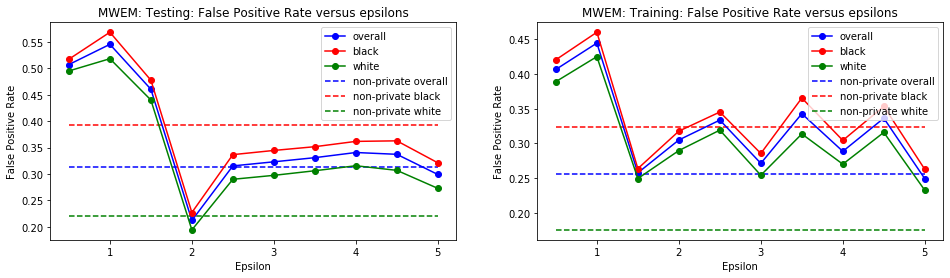

In [14]:
plotFPR("MWEM", test_results, train_results, epsilons)

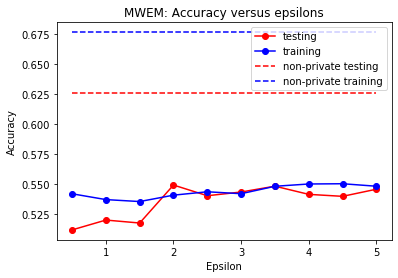

In [16]:
plotAccuracy("MWEM", test_results, train_results, epsilons)

We see private synthetic dataset has lower overall accuracy than the non-private real dataset, and as epsilon increases, the overall accuracy increases. Since epsilon represents the loss of privacy, the greater the epsilon means the dataset is more similar to the original one and thus has a more simialr (higher) overall accuracy.

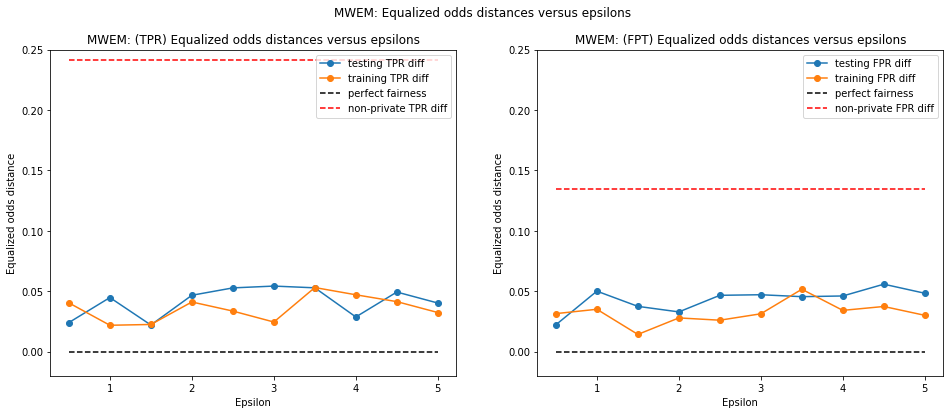

In [18]:
plotEqualizedOdds("MWEM", test_results, train_results, epsilons)


From the plot above, we see synthetic dataset is more fair than the non-private dataset, as the true positive rate(TPR) and false positive rate(FPR) differences are smaller and closer to 0, which represents perfect fairness. 

Now, for analysis purpose, we calculate the recidivism rate and the ratio of African-American people in the total population of the non-private original dataset.

In [19]:
print("The ratios of people who recidivated:", (df['two_year_recid']==1).sum()/df.shape[0])
print("The ratio of African-American people:", (df['race']==1).sum()/df.shape[0])

The ratios of people who recidivated: 0.47044334975369456
The ratio of African-American people: 0.6015536187949981


Next, examine whether synthetic differential private dataset will preserve these ratios versus different epsilons. 

In [96]:
epsilons = np.linspace(0.5,5,10)
ratio_results = np.load("COMPAS_fairness_mwem_analysis.npy", allow_pickle=True).item()

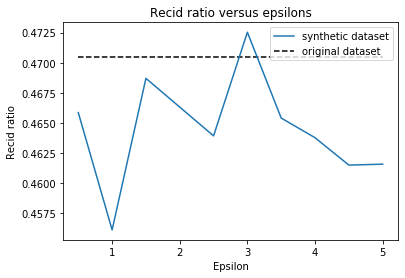

In [97]:
plotRecidRatio(epsilons, ratio_results["recid_ratio_avg"])

**Finding 1**: Recidivism ratio of synthetic DP data is align with the ratio of the original data by fluctuating around it and seem to be unrelated with the value of epsilon.

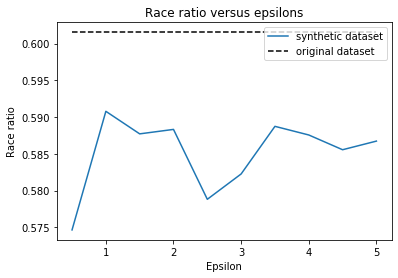

In [98]:
plotRaceRatio(epsilons, ratio_results["race_ratio_avg"])

**Finding 2:** But in terms of race ratio, synthetic data will try to lower the original one (60%) and thus make it more fair.

Next, we examine the ratios of four groups: 
* white who did not recedivate (24.27%)
* white who recedivated (15.57%)
* black who did not recedivate (28.69%)
* black who recedivated (31.47%)

in the non-private real dataset.

Two Year Recid        0        1
Race                            
0               0.24271  0.15574
1               0.28685  0.31470


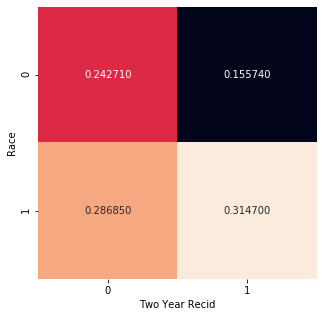

In [95]:
cm = pd.crosstab(df['race'], df['two_year_recid'], rownames=['Race'], colnames=['Two Year Recid'])
cm = round(cm/(df.shape[0]),5)
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt="f", cbar=False)
print(cm)

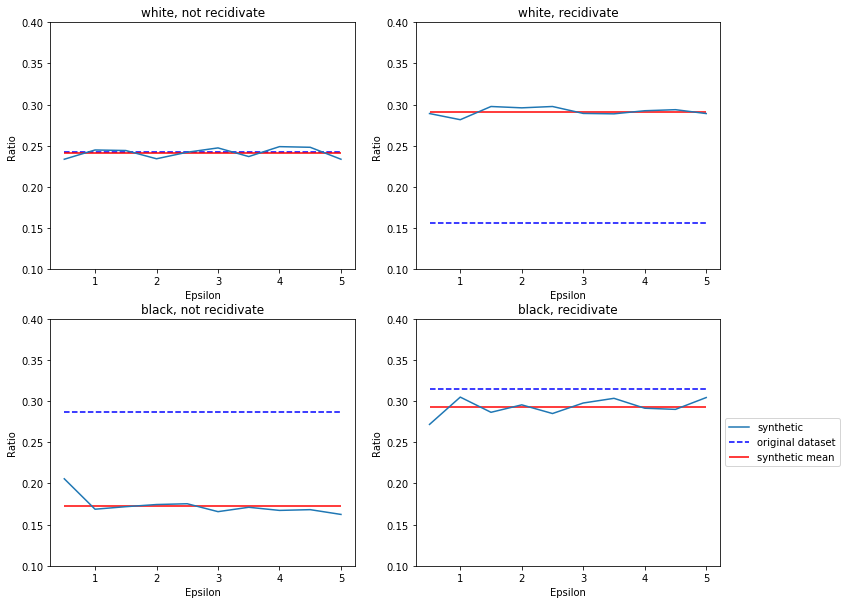

In [100]:
plotTable(epsilons, ratio_results["table00"],ratio_results["table01"],
          ratio_results["table10"],ratio_results["table11"])

**Finding 3:** Compared to the real data, synthetic dataset has
* almost the same ratio of white who did not recedivate 
* higher ratio of white who recedivated
* lower ratio of black who did not recedivate
* sligtly lower ratio of black who recedivated

To conclude, synthetic dataset generated by MWEM synthesizer is **more fair**. Some results that support this finding include the fact that synthetic dataset balances the ratio of black and white people in the whole population (if a dataset has more population of one group, the model will probably cheat by just predict that group to be 1, recidivate, and 0, not recidivate to the counterpart). It also increases the ratio of white who recedivated, suggesting the real dataset maybe underestimates the ratio of this group. 

For MWEM synthesizer, it firstly builds histogram for each data attributes. It holds big weights array for all the dimensions and iteratively tries to adjust those weights to a good value in the same way any update mechanism works. By scoring feature, it makes sure adjustments are made with noise. Therefore, with a 2-attribute binary class, we see any distribution it synthesized flatter - or to say, more fair. 

## 5.3 MWEM + QUAIL

In [ ]:
epsilons = list(range(1,6))
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_QUAIL.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

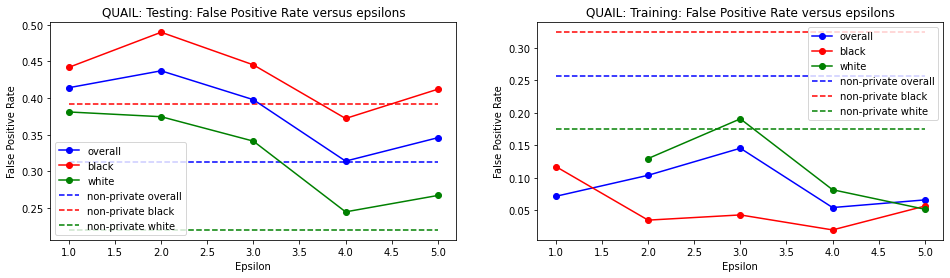

In [77]:
plotFPR("QUAIL", test_results, train_results, epsilons)

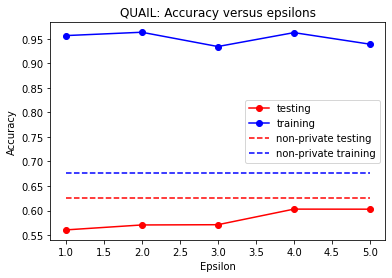

In [78]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

Similar to MWEM, we also observe the synthetic dataset has lower overall accuracy than the non-private dataset, and as epsilon increases, the overall accuracy increases. What it is different from MWEM is that training accuracy is much higher than testing accuracy, which indicates a overfitting here.

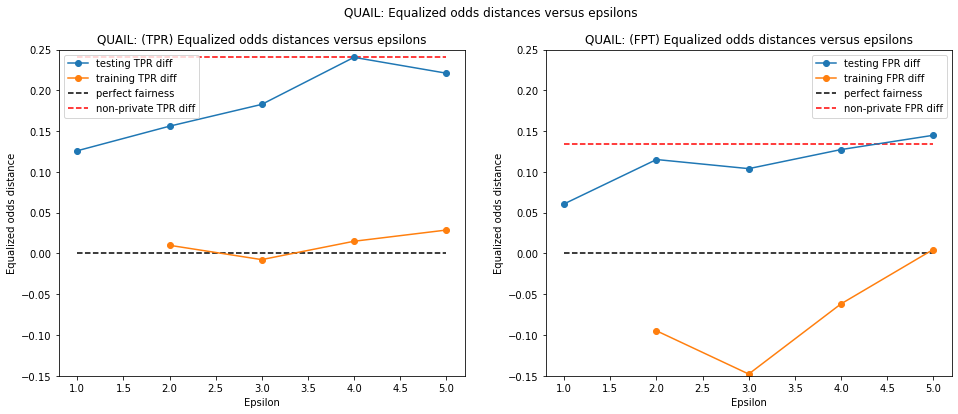

In [80]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons, [-0.15,0.25])

From the Equalized Odd Distances versus Epsilon plot, we see QUAIL synthesizer (similar to MWEM) creates more balanced classes, but increasing epsilon may have a disparate impact on the success rates of the protected classes, thereby improving fairness only at lower values of epsilon.

In [ ]:
# with 0.5 per iteration
epsilons = list(np.arange(1,6,0.5))

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL_2.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_QUAIL_2.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

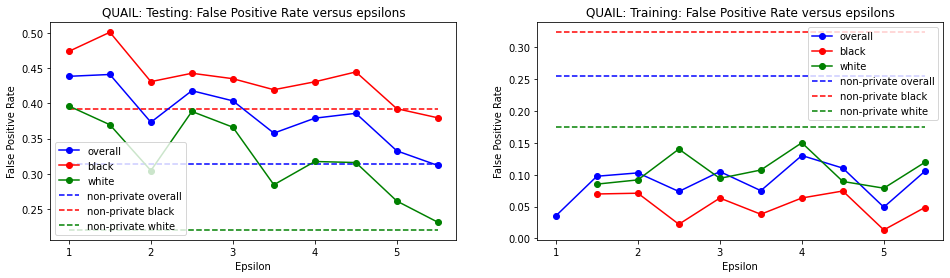

In [82]:
plotFPR("QUAIL", test_results, train_results, epsilons)

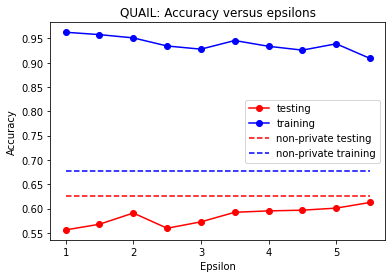

In [83]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

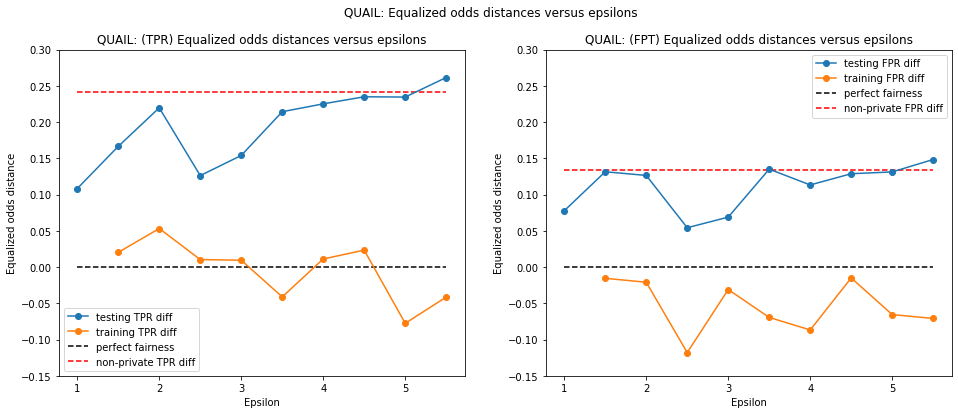

In [87]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons,[-0.15,0.30])

## 5.4 DPCTGAN

For DPCTGAN, the first GAN method we explored, we re-imported the data here because GAN-based methods are more capable of handling continuous variables, so we don't bin ages into three intervals $(<25, 25-50, >50)$ anymore. We take in age as a continuous variable directly, unlike what we did in MWEM and QUAIL. 

In [20]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df = process_COMPAS(df, is_GAN = True)

In [21]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=random.randint(0,100))

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [ ]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_DPCTGAN = np.load("COMPAS_fairness_DPCTGAN.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_DPCTGAN["train_results"], COMPAS_fairness_DPCTGAN["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="DPCTGAN")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_DPCTGAN.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

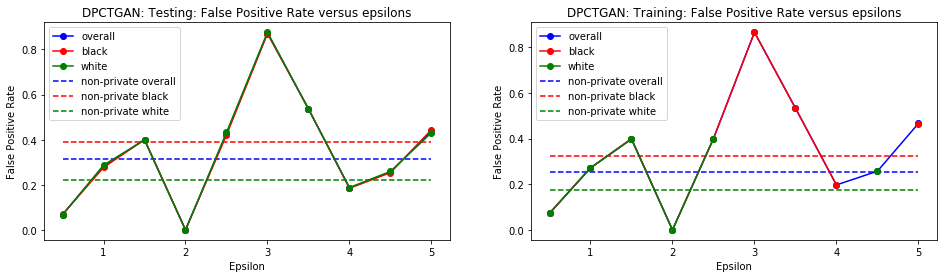

In [22]:
plotFPR("DPCTGAN", test_results, train_results, epsilons)

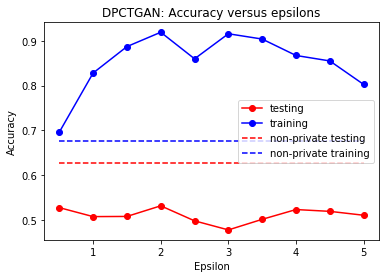

In [23]:
plotAccuracy("DPCTGAN", test_results, train_results, epsilons)

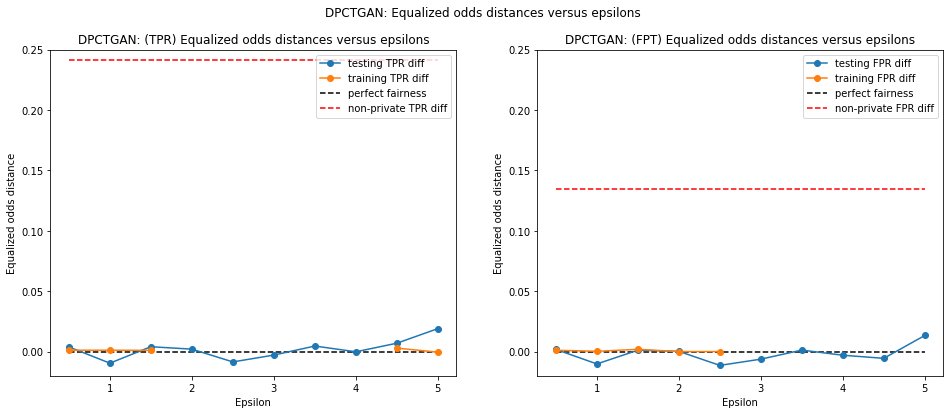

In [24]:
plotEqualizedOdds("DPCTGAN", test_results, train_results, epsilons,[-0.02,0.25])

Since we observe overfitting, we are curious to know if the accuracy is also low for synthetic testing data.

In [22]:
def average(all_results):
    nepsilons = len(all_results)
    niteration = len(all_results[0])
    avg_results = []
    for e in range(nepsilons): 
        overall, black, white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        for i in range(niteration):
            curr_overall, curr_black, curr_white = all_results[e][i][0],all_results[e][i][1],all_results[e][i][2]
            overall = [rate1+rate2 for rate1,rate2 in zip(overall,curr_overall)]
            white = [rate1+rate2 for rate1,rate2 in zip(white,curr_white)]
            black = [rate1+rate2 for rate1,rate2 in zip(black,curr_black)]
        
        overall = [rate/niteration for rate in overall]
        black = [rate/niteration for rate in black]
        white = [rate/niteration for rate in white]
        
        avg_results.append([overall,black,white])
    return avg_results

In [23]:
def load(results_dict):
    train_results = results_dict["avg_results"]["train_results"] 
    test_results = results_dict["avg_results"]["test_results"]
    test_synth_results = results_dict["avg_results"]["test_synth_results"]
    train_all_results = results_dict["all_results"]["train_all_results"]
    test_all_results = results_dict["all_results"]["test_all_results"]
    test_synth_all_results = results_dict["all_results"]["test_synth_all_results"]
    ratio_results = results_dict["ratio_results"]
    return train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results 

In [41]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_DPCTGAN_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "DPCTGAN", all_results = True)
    # calculate average result for synthetic test data
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_DPCTGAN_all_results.npy", results_dict)

train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)

in


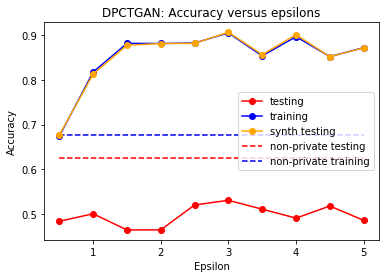

In [42]:
plotAccuracy("DPCTGAN", test_results, train_results, epsilons, test_synth_results)

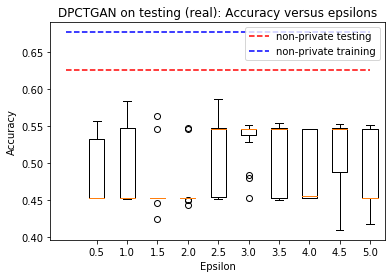

In [79]:
plotAccuracyBoxplot("DPCTGAN on testing (real)", test_all_results, epsilons)

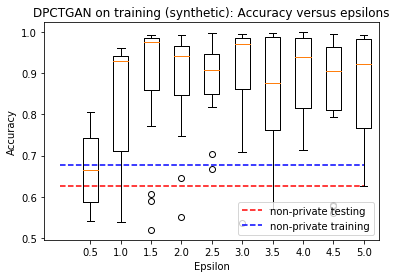

In [80]:
plotAccuracyBoxplot("DPCTGAN on training (synthetic)", train_all_results, epsilons)

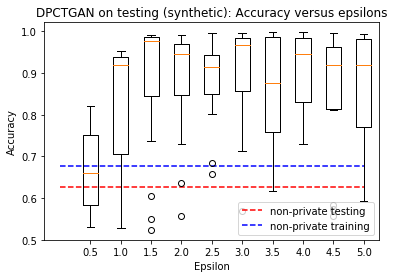

In [81]:
plotAccuracyBoxplot("DPCTGAN on testing (synthetic)", test_synth_all_results, epsilons)

In [91]:
def countAllZeroOneCase(epsilons, all_results):
    niterations = len(all_results[0])
    for i in range(len(epsilons)):
        count = 0
        for j in range(niterations):
            result = sorted(all_results[i][j][0][:4])
            if result[0] == 0 and result[1] == 0 and result[2] == 1 and result[3] == 1:
                count += 1
        print("Epsilon", epsilons[i], str(count)+"/"+str(niterations))
    return 

In [92]:
countAllZeroOneCase(epsilons, train_all_results)

Epsilon 0.5 10/15
Epsilon 1.0 14/15
Epsilon 1.5 13/15
Epsilon 2.0 12/15
Epsilon 2.5 12/15
Epsilon 3.0 13/15
Epsilon 3.5 14/15
Epsilon 4.0 14/15
Epsilon 4.5 10/15
Epsilon 5.0 13/15


In [94]:
countAllZeroOneCase(epsilons, test_synth_all_results)

Epsilon 0.5 11/15
Epsilon 1.0 14/15
Epsilon 1.5 12/15
Epsilon 2.0 13/15
Epsilon 2.5 14/15
Epsilon 3.0 12/15
Epsilon 3.5 14/15
Epsilon 4.0 14/15
Epsilon 4.5 12/15
Epsilon 5.0 13/15


In [93]:
countAllZeroOneCase(epsilons, test_all_results)

Epsilon 0.5 11/15
Epsilon 1.0 8/15
Epsilon 1.5 12/15
Epsilon 2.0 10/15
Epsilon 2.5 8/15
Epsilon 3.0 8/15
Epsilon 3.5 6/15
Epsilon 4.0 11/15
Epsilon 4.5 8/15
Epsilon 5.0 9/15


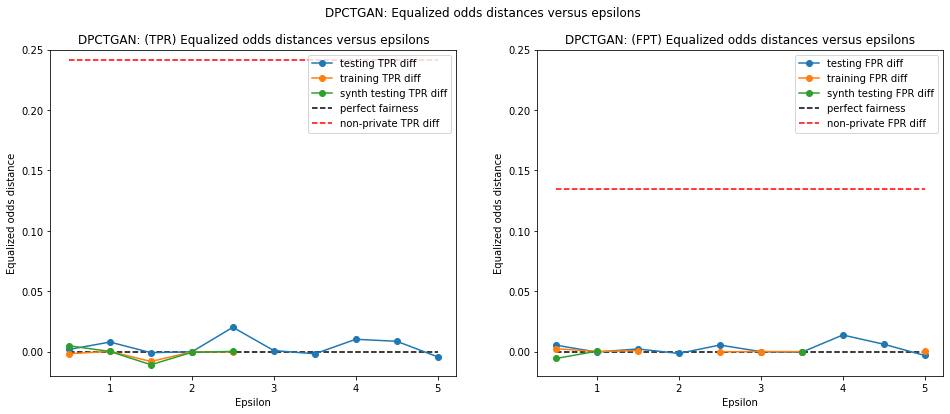

In [43]:
plotEqualizedOdds("DPCTGAN", test_results, train_results, epsilons, (-0.02,0.25), test_synth_results)

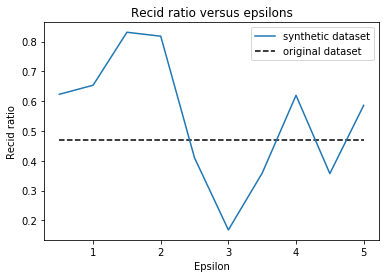

In [44]:
plotRecidRatio(epsilons, ratio_results["recid_ratio_avg"])

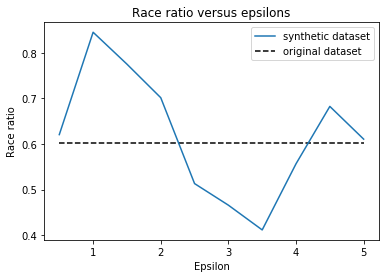

In [45]:
plotRaceRatio(epsilons, ratio_results["race_ratio_avg"])

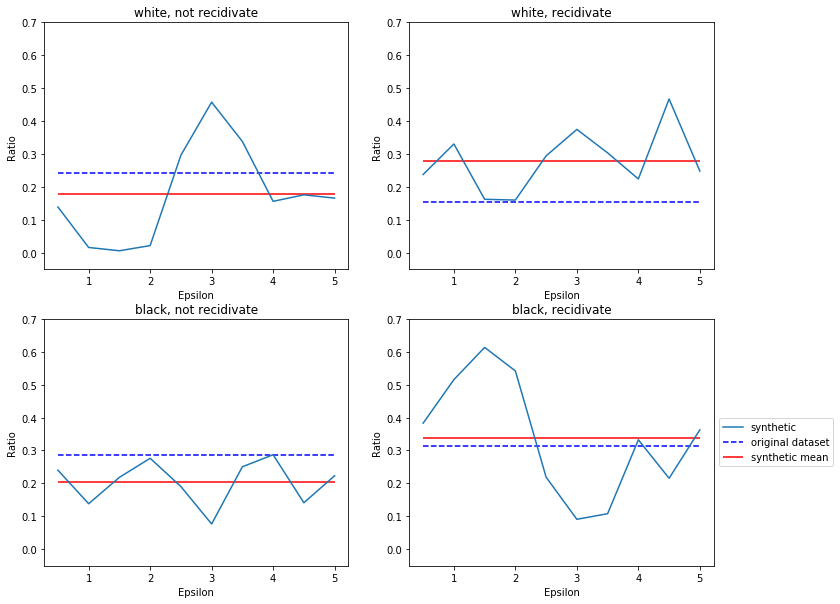

In [46]:
plotTable(epsilons, ratio_results["table00"],ratio_results["table01"],
          ratio_results["table10"],ratio_results["table11"], ylim=(-0.05,0.7))

## 5.5 PATECTGAN

In [25]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_PATECTGAN = np.load("COMPAS_fairness_PATECTGAN.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_PATECTGAN["train_results"], COMPAS_fairness_PATECTGAN["test_results"]
except: 
    results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="PATECTGAN")
    test_results, train_results = results[0], results[1]
    np.save("COMPAS_fairness_PATECTGAN.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

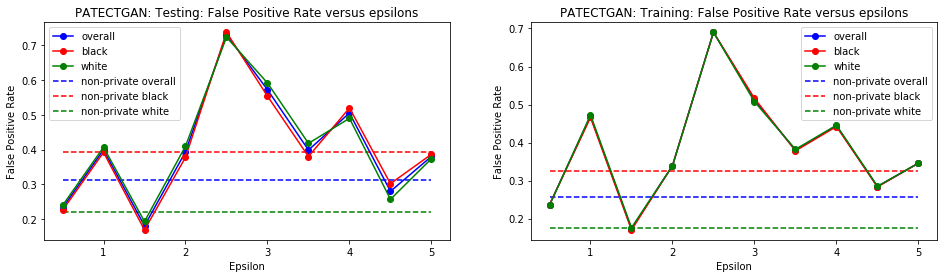

In [26]:
plotFPR("PATECTGAN", test_results, train_results, epsilons)

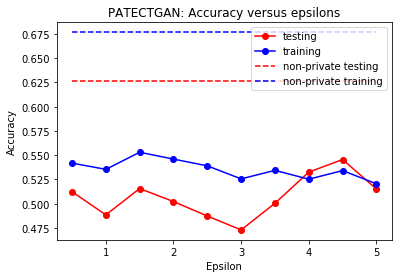

In [27]:
plotAccuracy("PATECTGAN", test_results, train_results, epsilons)

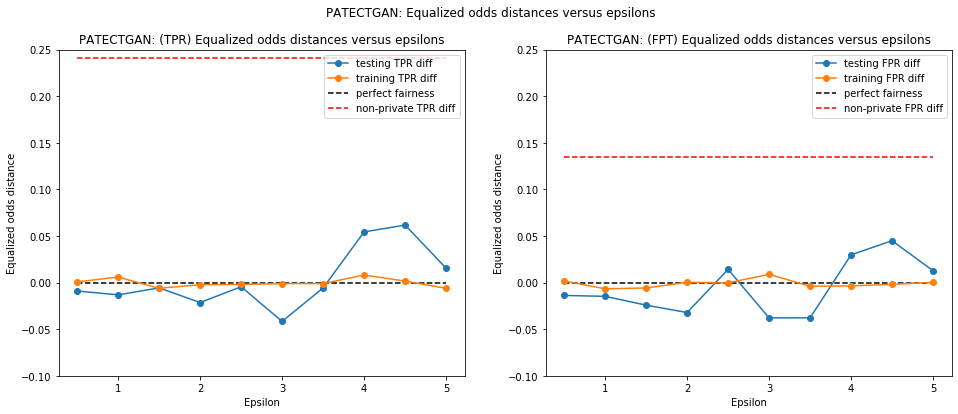

In [29]:
plotEqualizedOdds("PATECTGAN", test_results, train_results, epsilons, ylim=(-0.10,0.25))

In [150]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_PATECTGAN_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "PATECTGAN", all_results = True)
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_PATECTGAN_all_results.npy", results_dict)
    
train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)


in


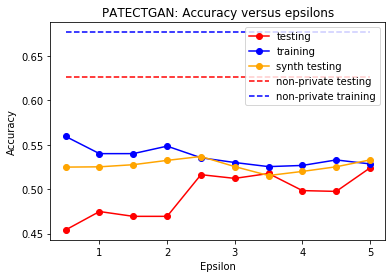

In [151]:
plotAccuracy("PATECTGAN", test_results, train_results, epsilons, test_synth_results)

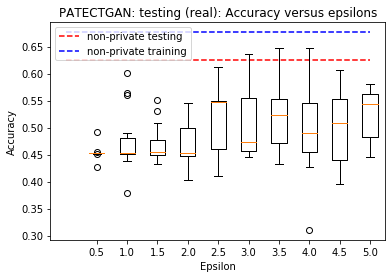

In [97]:
plotAccuracyBoxplot("PATECTGAN: testing (real)", test_all_results, epsilons)

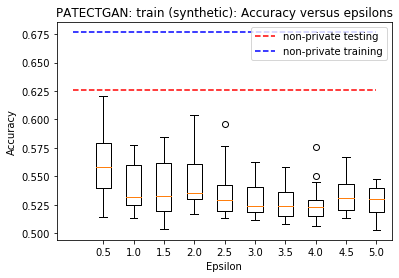

In [98]:
plotAccuracyBoxplot("PATECTGAN: train (synthetic)", train_all_results, epsilons)

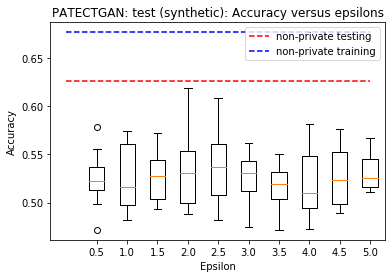

In [99]:
plotAccuracyBoxplot("PATECTGAN: test (synthetic)", test_synth_all_results, epsilons)

In [152]:
countAllZeroOneCase(epsilons, test_all_results)

Epsilon 0.5 7/15
Epsilon 1.0 4/15
Epsilon 1.5 1/15
Epsilon 2.0 2/15
Epsilon 2.5 1/15
Epsilon 3.0 4/15
Epsilon 3.5 1/15
Epsilon 4.0 1/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15


In [153]:
countAllZeroOneCase(epsilons, train_all_results)

Epsilon 0.5 5/15
Epsilon 1.0 2/15
Epsilon 1.5 1/15
Epsilon 2.0 2/15
Epsilon 2.5 0/15
Epsilon 3.0 1/15
Epsilon 3.5 1/15
Epsilon 4.0 1/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15


In [154]:
countAllZeroOneCase(epsilons, test_synth_all_results)

Epsilon 0.5 6/15
Epsilon 1.0 2/15
Epsilon 1.5 2/15
Epsilon 2.0 2/15
Epsilon 2.5 1/15
Epsilon 3.0 2/15
Epsilon 3.5 1/15
Epsilon 4.0 1/15
Epsilon 4.5 0/15
Epsilon 5.0 1/15


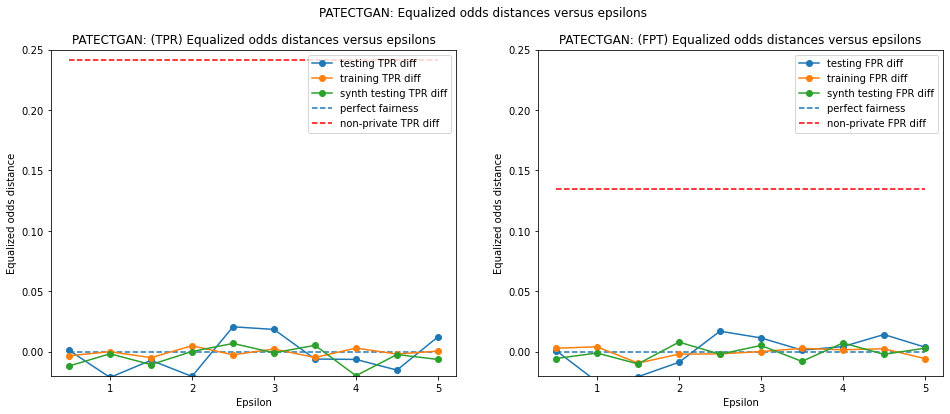

In [28]:
plotEqualizedOdds("PATECTGAN", test_results, train_results, epsilons, (-0.02,0.25), test_synth_results)

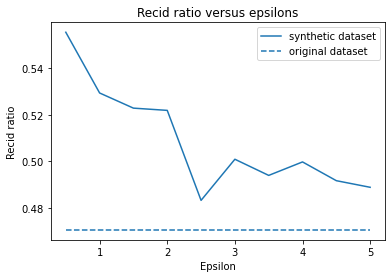

In [29]:
plotRecidRatio(epsilons, ratio_results["recid_ratio_avg"])

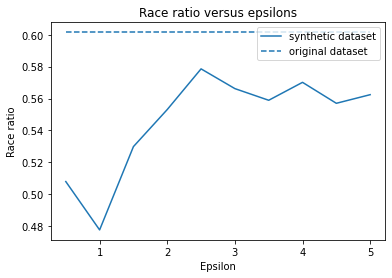

In [30]:
plotRaceRatio(epsilons, ratio_results["race_ratio_avg"])

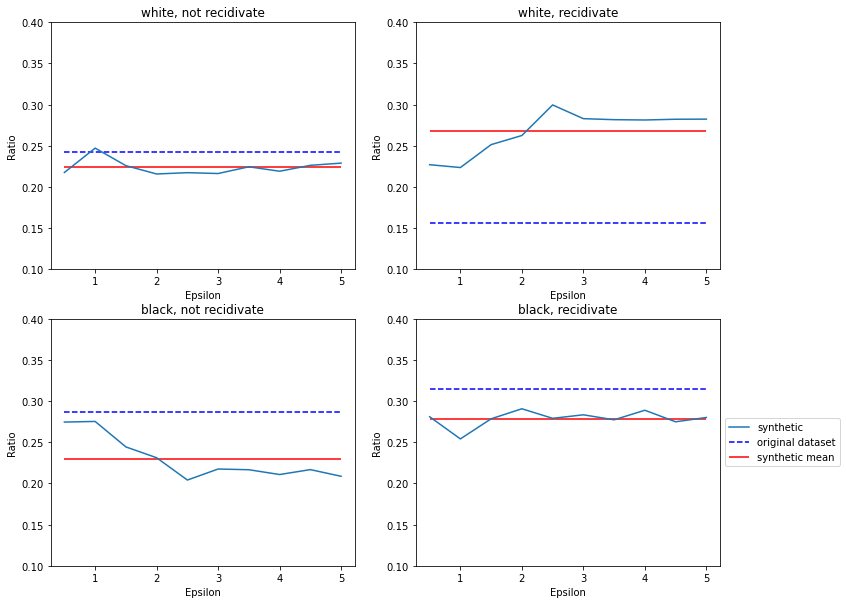

In [31]:
plotTable(epsilons, ratio_results["table00"],ratio_results["table01"],
          ratio_results["table10"],ratio_results["table11"])

## 5.6 DPCTGAN + QUAIL

In [121]:
epsilons = np.linspace(0.5,8,16)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_DPCTGANQUAIL_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "DPCTGANQUAIL", all_results = True)
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_DPCTGANQUAIL_all_results.npy", results_dict)
    
train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)

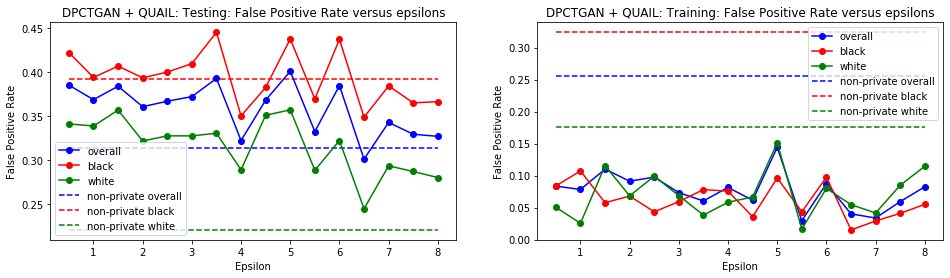

In [134]:
plotFPR("DPCTGAN + QUAIL", test_results, train_results, epsilons)

in


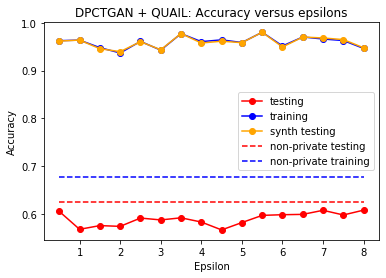

In [135]:
plotAccuracy("DPCTGAN + QUAIL", test_results, train_results, epsilons, test_synth_results)

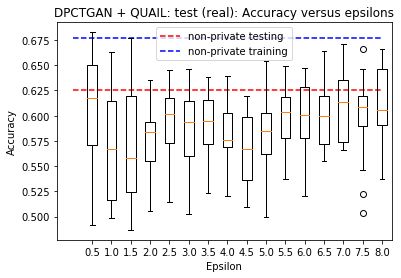

In [136]:
plotAccuracyBoxplot("DPCTGAN + QUAIL: test (real)", test_all_results, epsilons)

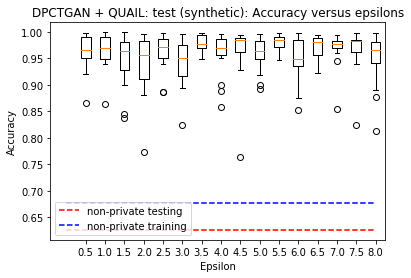

In [137]:
plotAccuracyBoxplot("DPCTGAN + QUAIL: test (synthetic)", test_synth_all_results, epsilons)

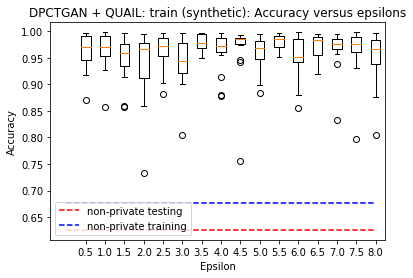

In [138]:
plotAccuracyBoxplot("DPCTGAN + QUAIL: train (synthetic)", train_all_results, epsilons)

In [128]:
countAllZeroOneCase(epsilons, test_all_results)

Epsilon 0.5 0/15
Epsilon 1.0 0/15
Epsilon 1.5 0/15
Epsilon 2.0 0/15
Epsilon 2.5 0/15
Epsilon 3.0 0/15
Epsilon 3.5 0/15
Epsilon 4.0 0/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15
Epsilon 5.5 0/15
Epsilon 6.0 0/15
Epsilon 6.5 0/15
Epsilon 7.0 0/15
Epsilon 7.5 0/15
Epsilon 8.0 0/15


In [129]:
countAllZeroOneCase(epsilons, test_synth_all_results)

Epsilon 0.5 0/15
Epsilon 1.0 0/15
Epsilon 1.5 0/15
Epsilon 2.0 0/15
Epsilon 2.5 0/15
Epsilon 3.0 0/15
Epsilon 3.5 0/15
Epsilon 4.0 0/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15
Epsilon 5.5 0/15
Epsilon 6.0 0/15
Epsilon 6.5 0/15
Epsilon 7.0 0/15
Epsilon 7.5 0/15
Epsilon 8.0 0/15


In [131]:
countAllZeroOneCase(epsilons, train_all_results)

Epsilon 0.5 0/15
Epsilon 1.0 0/15
Epsilon 1.5 0/15
Epsilon 2.0 0/15
Epsilon 2.5 0/15
Epsilon 3.0 0/15
Epsilon 3.5 0/15
Epsilon 4.0 0/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15
Epsilon 5.5 0/15
Epsilon 6.0 0/15
Epsilon 6.5 0/15
Epsilon 7.0 0/15
Epsilon 7.5 0/15
Epsilon 8.0 0/15


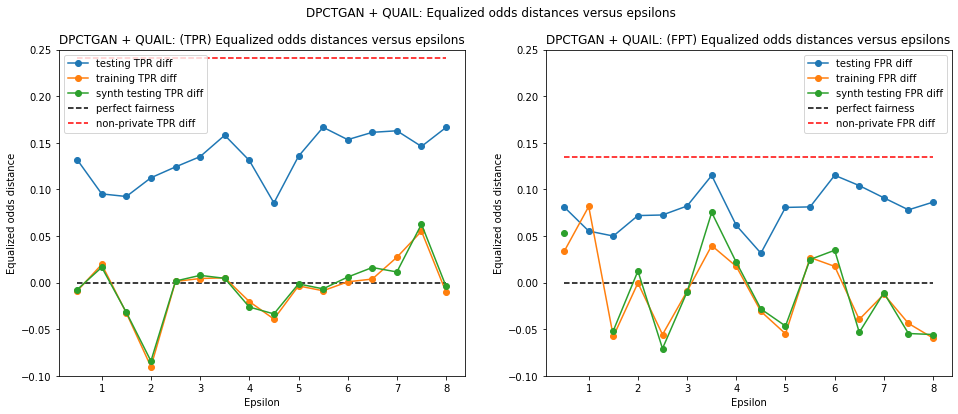

In [141]:
plotEqualizedOdds("DPCTGAN + QUAIL", test_results, train_results, epsilons, (-0.10,0.25), test_synth_results)

For DPCTGAN + QUAIL, we see a improvement in accuracy rate (higher than DPCTGAN alone and similar to MWEM+QUAIL). The logistic regression model no longer cheats by just guessing all 1s or all 0s. However, the overfitting pattern still exists and distribution of accuracy is very similar between synthetic training and synthetic testing, which differs a lot from that of real testing. Furthermore, the accuracy gains is at the price of fairness. Though the synthetic training and synthetic testing datasets are very fair, testing on real data shows the equalized odds distances are large.

## 5.7 PATECTGAN + QUAIL

In [155]:
epsilons = np.linspace(0.5,8,16)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_PATECTGANQUAIL_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "PATECTGANQUAIL", all_results = True)
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_PATECTGANQUAIL_all_results.npy", results_dict)
    
train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)

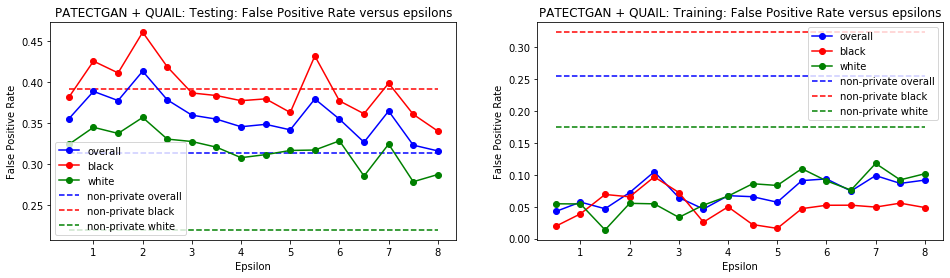

In [156]:
plotFPR("PATECTGAN + QUAIL", test_results, train_results, epsilons)

in


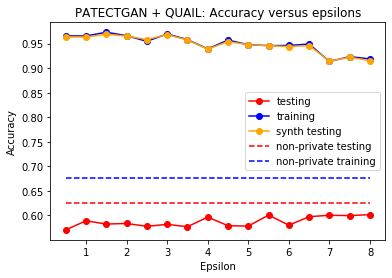

In [157]:
plotAccuracy("PATECTGAN + QUAIL", test_results, train_results, epsilons, test_synth_results)

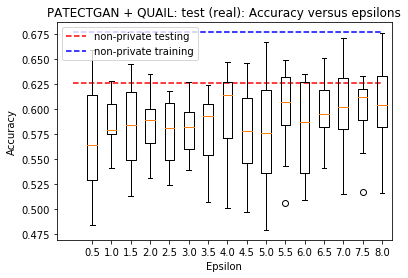

In [145]:
plotAccuracyBoxplot("PATECTGAN + QUAIL: test (real)", test_all_results, epsilons)

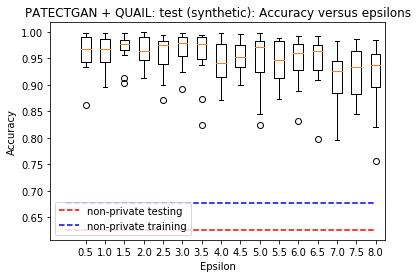

In [146]:
plotAccuracyBoxplot("PATECTGAN + QUAIL: test (synthetic)", test_synth_all_results, epsilons)

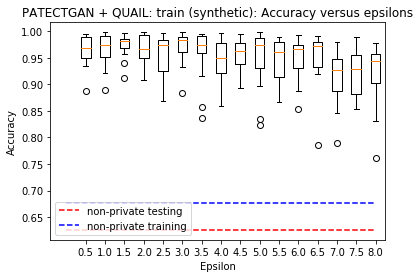

In [148]:
plotAccuracyBoxplot("PATECTGAN + QUAIL: train (synthetic)", train_all_results, epsilons)

In [149]:
countAllZeroOneCase(epsilons, test_all_results)

Epsilon 0.5 0/15
Epsilon 1.0 0/15
Epsilon 1.5 0/15
Epsilon 2.0 0/15
Epsilon 2.5 0/15
Epsilon 3.0 0/15
Epsilon 3.5 0/15
Epsilon 4.0 0/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15
Epsilon 5.5 0/15
Epsilon 6.0 0/15
Epsilon 6.5 0/15
Epsilon 7.0 0/15
Epsilon 7.5 0/15
Epsilon 8.0 0/15


In [158]:
countAllZeroOneCase(epsilons, test_synth_all_results)

Epsilon 0.5 0/15
Epsilon 1.0 0/15
Epsilon 1.5 0/15
Epsilon 2.0 0/15
Epsilon 2.5 0/15
Epsilon 3.0 0/15
Epsilon 3.5 0/15
Epsilon 4.0 0/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15
Epsilon 5.5 0/15
Epsilon 6.0 0/15
Epsilon 6.5 0/15
Epsilon 7.0 0/15
Epsilon 7.5 0/15
Epsilon 8.0 0/15


In [160]:
countAllZeroOneCase(epsilons, train_all_results)

Epsilon 0.5 0/15
Epsilon 1.0 0/15
Epsilon 1.5 0/15
Epsilon 2.0 0/15
Epsilon 2.5 0/15
Epsilon 3.0 0/15
Epsilon 3.5 0/15
Epsilon 4.0 0/15
Epsilon 4.5 0/15
Epsilon 5.0 0/15
Epsilon 5.5 0/15
Epsilon 6.0 0/15
Epsilon 6.5 0/15
Epsilon 7.0 0/15
Epsilon 7.5 0/15
Epsilon 8.0 0/15


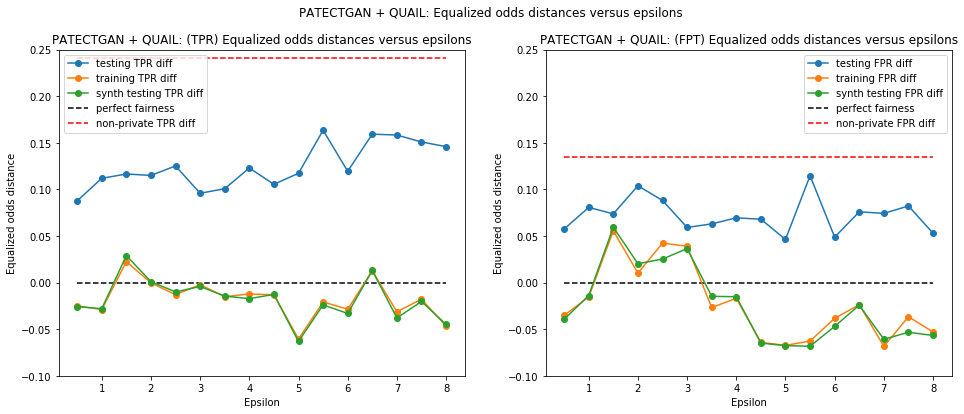

In [161]:
plotEqualizedOdds("PATECTGAN + QUAIL", test_results, train_results, epsilons, (-0.10,0.25), test_synth_results)

Next, try PATECTGAN + QUAIL with regularization 'dragan'.

In [170]:
epsilons = np.linspace(0.5,8,16)
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("COMPAS_fairness_PATECTGANQUAIL_dragan_all_results.npy", allow_pickle=True).item()
    
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer = "PATECTGANQUAIL", all_results = True)
    results_dict["avg_results"]["test_synth_results"] = average(results_dict["all_results"]["test_synth_all_results"])
    np.save("COMPAS_fairness_PATECTGANQUAIL_dragan_all_results.npy", results_dict)
    
train_results, test_results, test_synth_results, train_all_results, test_all_results, test_synth_all_results, ratio_results = load(results_dict)

in


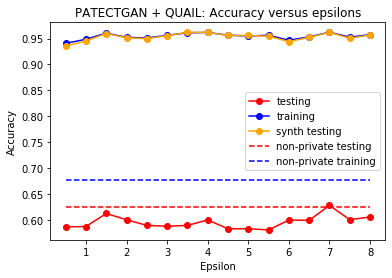

In [165]:
plotAccuracy("PATECTGAN + QUAIL", test_results, train_results, epsilons, test_synth_results)

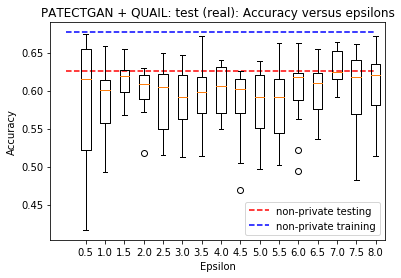

In [166]:
plotAccuracyBoxplot("PATECTGAN + QUAIL: test (real)", test_all_results, epsilons)

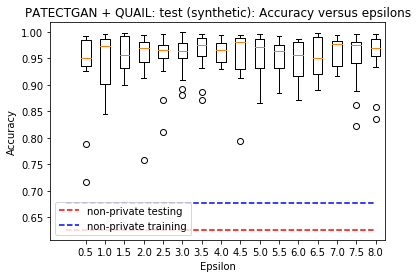

In [167]:
plotAccuracyBoxplot("PATECTGAN + QUAIL: test (synthetic)", test_synth_all_results, epsilons)

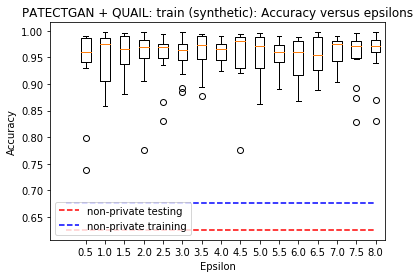

In [168]:
plotAccuracyBoxplot("PATECTGAN + QUAIL: train (synthetic)", train_all_results, epsilons)

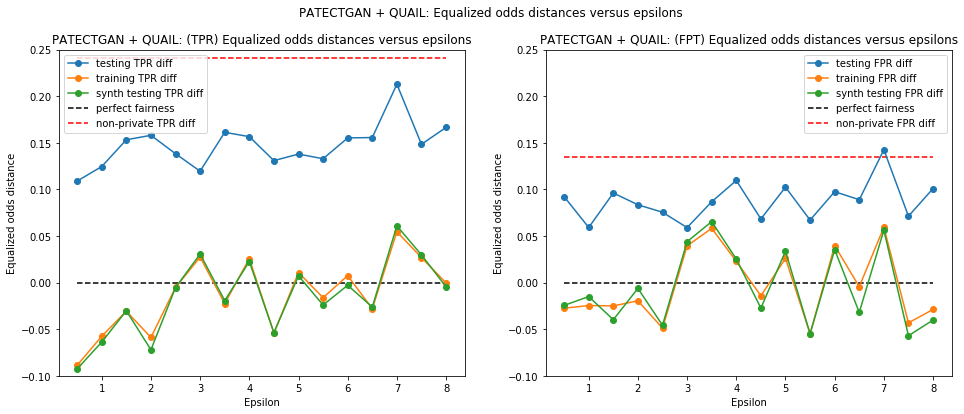

In [169]:
plotEqualizedOdds("PATECTGAN + QUAIL", test_results, train_results, epsilons, (-0.10,0.25), test_synth_results)